# Performing QSO Classification using Variational Autoencoders¶

This notebook performs Quasar Classification using variational autoencoders.


## Authors

* Ash Karale
    

## Contents:

1. Importing Modules
2. Data Acquisition
3. Data Processing
4. Model Definition
5. Model Training


## Versions:

Initial Version: November 2022 (Ash Karale)


### 1. Importing Modules

In [2]:
#Importing all required modules

#system modules 
import os
import sys
import importlib
import pickle
import argparse
import itertools
import csv
from tqdm import tqdm
import time

#mathematical operations
import math
import numpy as np
import pandas as pd

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
#pd.set_option('display.max_columns', 1000)

#sklearn
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

#scipy
from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

#astropy
from astropy.io import fits
from astropy.table import Table

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

print(sys.version)

3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]


### 2. Data Acquisition

In [3]:
data_dir = '/Users/ash/Research/Data/DELVE/'

# Examine the data directory
display(data_dir)

'/Users/ash/Research/Data/DELVE/'

Reading in the data file

In [4]:
from astropy.table import Table
data = Table.read(os.path.join(data_dir, 'fullcat0_15.fits'))
fc015_df = data.to_pandas()

Inspecting the data file

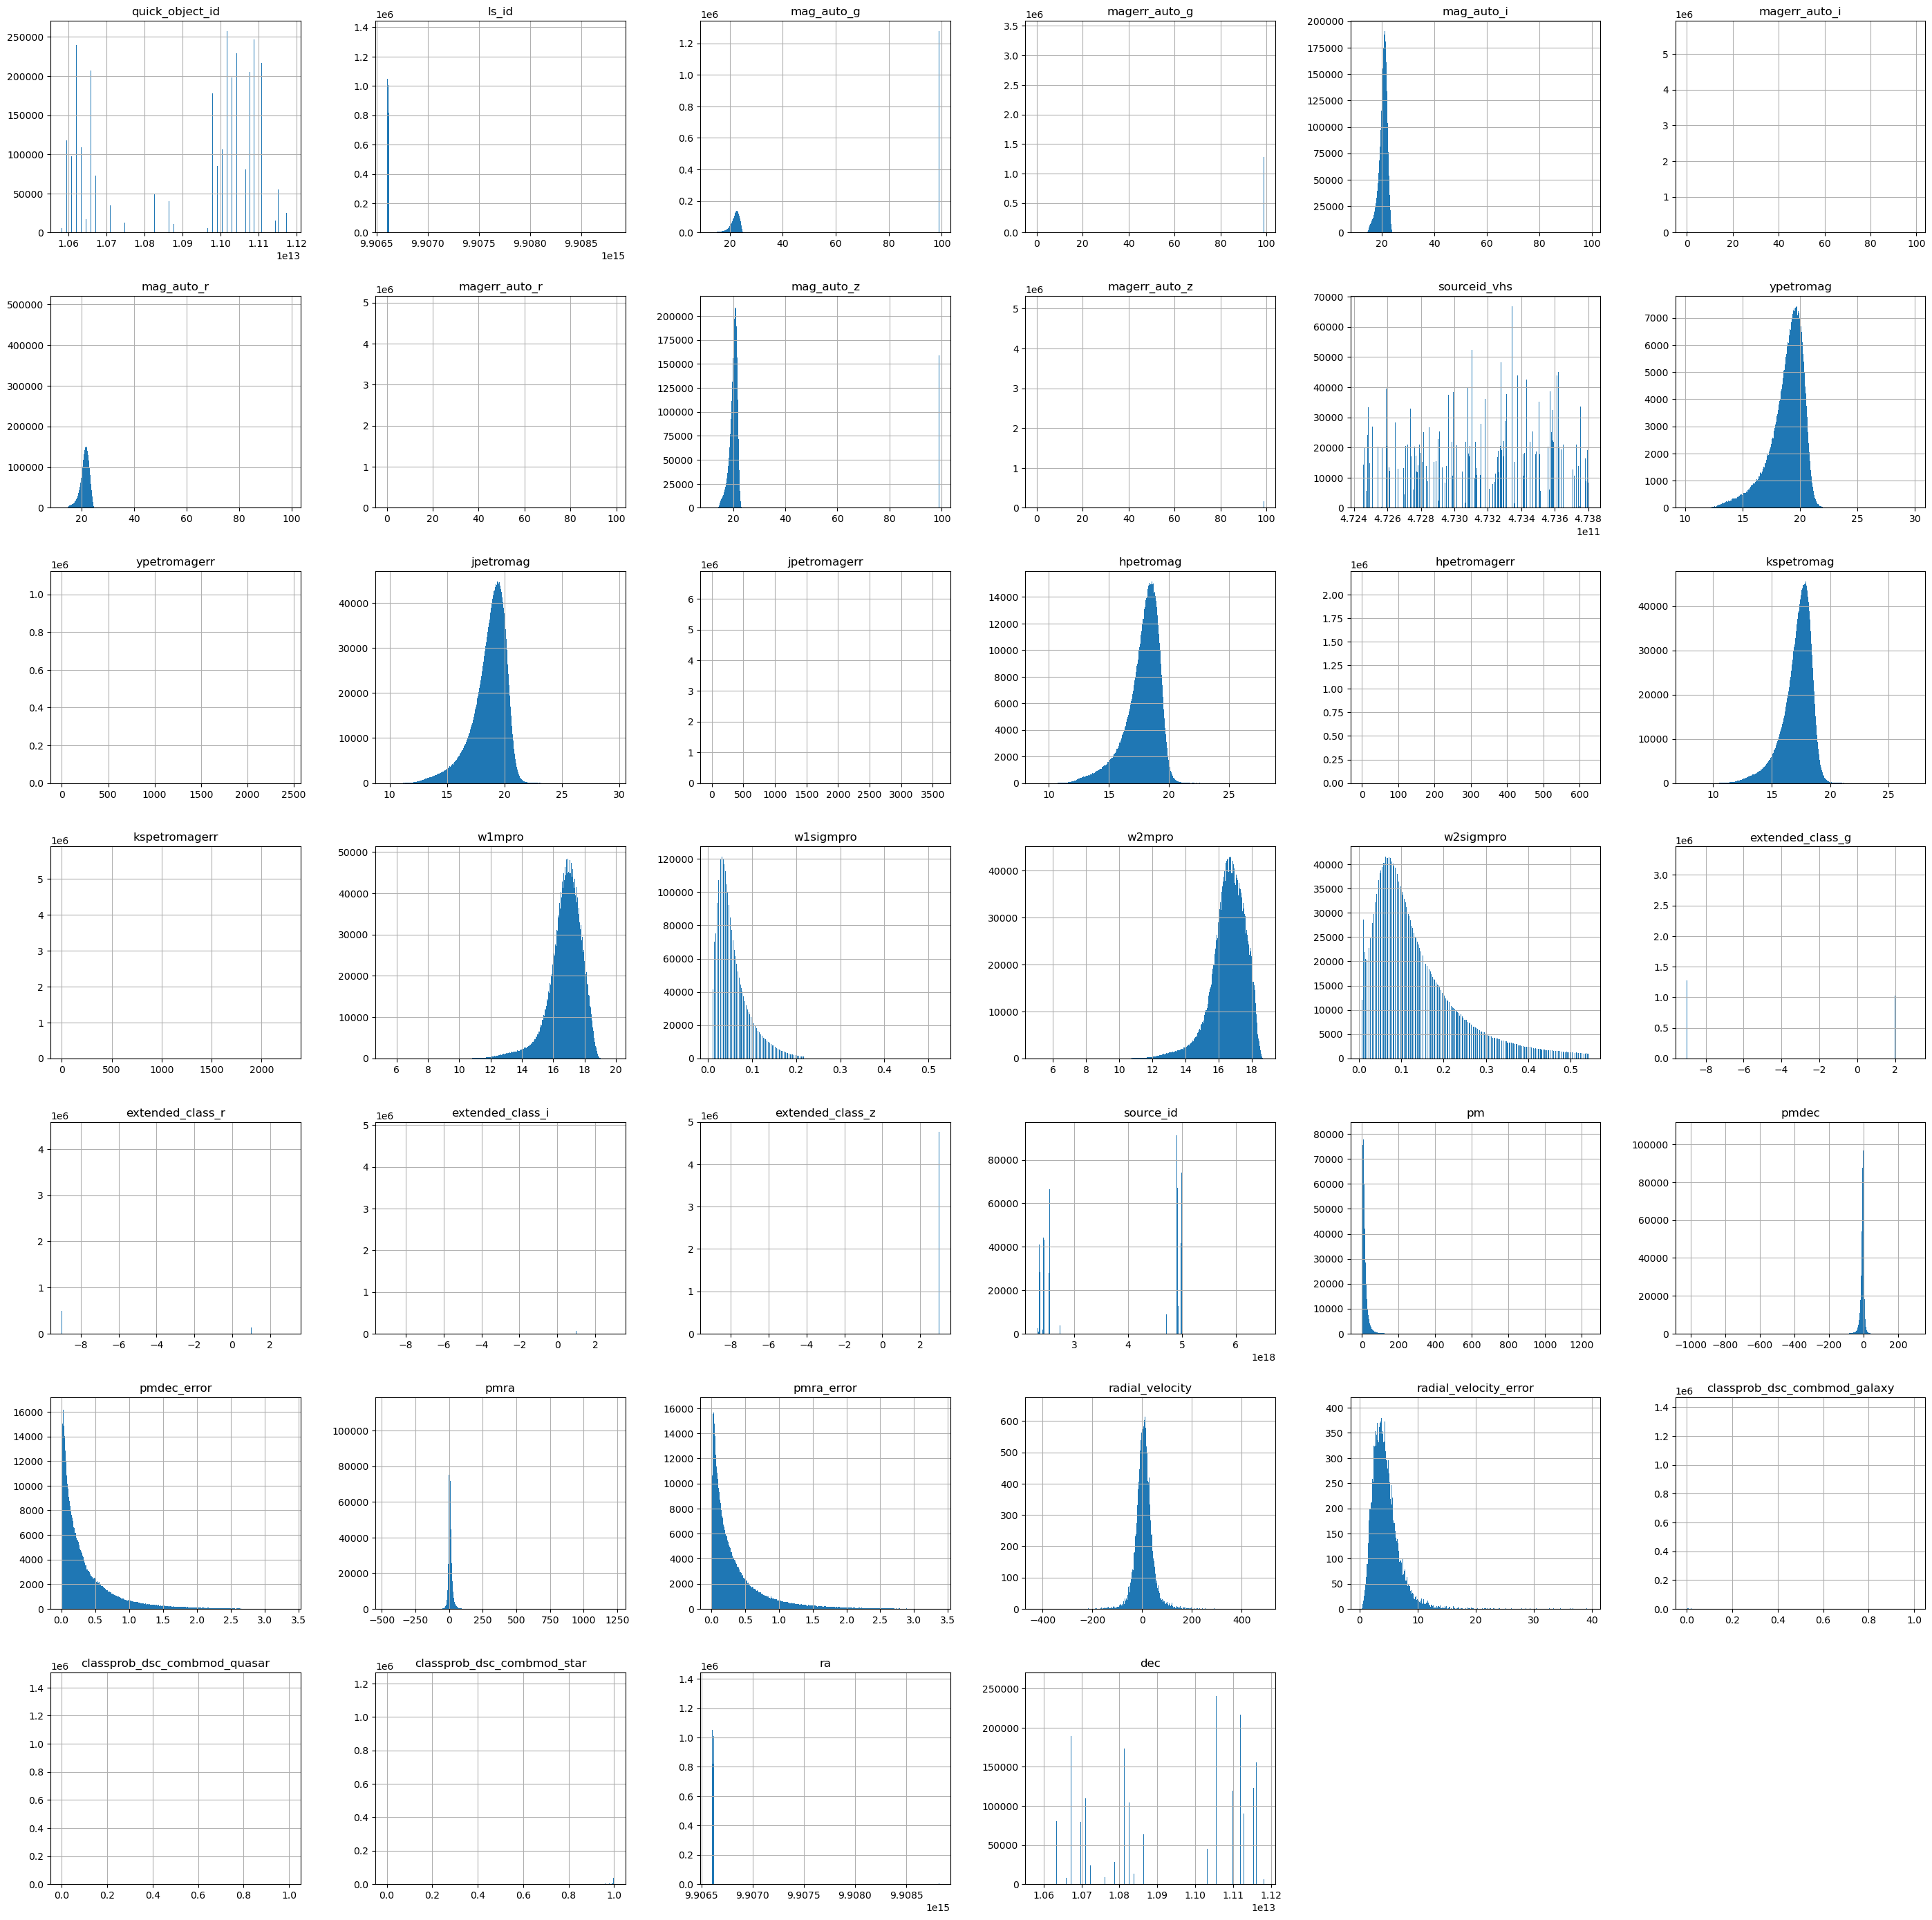

True     5641792
False    1518797
Name: classprob_dsc_combmod_quasar, dtype: int64

0.000000    1192644
1.000000      13500
0.000001       8961
0.000002       5705
0.000004       4020
             ...   
0.063430          1
0.013086          1
0.811445          1
0.063494          1
0.965353          1
Name: classprob_dsc_combmod_quasar, Length: 31409, dtype: int64

1518797

,quick_object_id,ls_id,mag_auto_g,magerr_auto_g,mag_auto_i,magerr_auto_i,mag_auto_r,magerr_auto_r,mag_auto_z,magerr_auto_z,...,pmdec_error,pmra,pmra_error,radial_velocity,radial_velocity_error,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,ra,dec
count,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,7.160589e+06,...,1.227089e+06,1.227089e+06,1.227089e+06,42817.000000,42817.000000,1.518797e+06,1.518797e+06,1.518797e+06,7.160589e+06,7.160589e+06
mean,1.091891e+13,9.906613e+15,3.568570e+01,1.775734e+01,2.250902e+01,2.546375e+00,2.655977e+01,6.918337e+00,2.189861e+01,2.268815e+00,...,3.713999e-01,7.965524e+00,3.740253e-01,7.539349,4.535558,3.777179e-02,2.248826e-02,9.363162e-01,9.906613e+15,1.091891e+13
std,1.986876e+11,7.287523e+10,2.956152e+01,3.787102e+01,1.237510e+01,1.548371e+01,1.982174e+01,2.510584e+01,1.170724e+01,1.457422e+01,...,4.190298e-01,1.631142e+01,4.310881e-01,39.338131,2.461152,1.878661e-01,1.427082e-01,2.393870e-01,7.287523e+10,1.986876e+11
min,1.058240e+13,9.906601e+15,1.327900e+01,2.750000e-04,1.239584e+01,2.570000e-04,1.244637e+01,2.710000e-04,1.183939e+01,3.120000e-04,...,8.900000e-03,-4.632060e+02,6.437000e-03,-423.485200,0.398178,0.000000e+00,0.000000e+00,0.000000e+00,9.906601e+15,1.058240e+13
25%,1.069770e+13,9.906604e+15,2.140725e+01,3.827700e-02,1.978063e+01,1.888000e-02,2.037124e+01,2.044000e-02,1.945737e+01,2.592600e-02,...,8.983000e-02,1.873683e-01,8.884000e-02,-11.124219,2.930553,0.000000e+00,0.000000e+00,9.993890e-01,9.906604e+15,1.069770e+13
50%,1.100520e+13,9.906607e+15,2.269690e+01,1.072780e-01,2.083274e+01,4.480800e-02,2.154440e+01,5.203100e-02,2.047554e+01,6.077800e-02,...,2.235360e-01,5.523806e+00,2.213080e-01,6.576803,4.087296,0.000000e+00,0.000000e+00,9.999550e-01,9.906607e+15,1.100520e+13
75%,1.109880e+13,9.906618e+15,2.400039e+01,2.483210e-01,2.167509e+01,8.807500e-02,2.264917e+01,1.259950e-01,2.123571e+01,1.097290e-01,...,4.925720e-01,1.292446e+01,4.863860e-01,24.664055,5.562451,0.000000e+00,0.000000e+00,9.999890e-01,9.906618e+15,1.109880e+13
max,1.118100e+13,9.908821e+15,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,...,3.355908e+00,1.226014e+03,3.370114e+00,489.906740,39.473698,1.000000e+00,1.000000e+00,1.000000e+00,9.908821e+15,1.118100e+13


,quick_object_id,ls_id,mag_auto_g,magerr_auto_g,mag_auto_i,magerr_auto_i,mag_auto_r,magerr_auto_r,mag_auto_z,magerr_auto_z,...,pmdec_error,pmra,pmra_error,radial_velocity,radial_velocity_error,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,ra,dec
0.95,1.116040e+13,9.906621e+15,99.0,99.0,22.962113,0.219676,99.0,99.0,22.211456,0.216361,...,1.25196,32.439177,1.279387,63.660905,8.736328,0.01315,0.001463,0.999997,9.906621e+15,1.116040e+13


(7160589, 41)

In [5]:
fc015_df.hist(figsize = [35, 35], bins=1000)
plt.show()
display(fc015_df['classprob_dsc_combmod_quasar'].isna().value_counts())
display(fc015_df['classprob_dsc_combmod_quasar'].value_counts(), fc015_df['classprob_dsc_combmod_quasar'].value_counts().sum())
display(fc015_df.describe())
display(fc015_df.quantile([0.95]))
display(fc015_df.shape)

Checking the columns

In [6]:
fc015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160589 entries, 0 to 7160588
Data columns (total 41 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   quick_object_id               int64  
 1   ls_id                         int64  
 2   mag_auto_g                    float64
 3   magerr_auto_g                 float64
 4   mag_auto_i                    float64
 5   magerr_auto_i                 float64
 6   mag_auto_r                    float64
 7   magerr_auto_r                 float64
 8   mag_auto_z                    float64
 9   magerr_auto_z                 float64
 10  sourceid_vhs                  int64  
 11  ypetromag                     float64
 12  ypetromagerr                  float64
 13  jpetromag                     float64
 14  jpetromagerr                  float64
 15  hpetromag                     float64
 16  hpetromagerr                  float64
 17  kspetromag                    float64
 18  kspetromagerr         

### 3. Data processing

In [8]:
# Splitting the data without employing stratification & removing the quasar class from the test sample

for row in fc015_df:
    data = dict()
    data.update(local_timestamp = row[0])
    data.update(nse_timestamp = float(row[1].strip('_')))

X = fc015_df.drop(['classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classprob_dsc_combmod_star','ra','dec'], axis=1)
y = fc015_df['classprob_dsc_combmod_quasar']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 123)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size = 0.66, 
                                                                random_state = 123)


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


fc015_df(X_test, columns=X.columns).hist(figsize = [35, 35], bins=500)
plt.show()
display(X_train.shape, X_val.shape, X_test.shape)

ValueError: could not convert string to float: 'u'

### 4. Model Definition

Defining functions for the VAE

In [ ]:
def acc_f(y_true, y_pred):
    """
    # Arguments
    y: true labels, numpy.array with shape (n_samples,)
    y_pred: predicted labels, numpy.array with shape (n_samples,)
    # Return
    accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
        ind = np.transpose(np.asarray(linear_assignment(w.max() - w)))
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

nmi_f = normalized_mutual_info_score
ari_f = adjusted_rand_score

def label_assignement(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    original_labels = np.array([0, 1, 2]) # 0 Star, 1 Gal, 2 Qso
    unsupervised_labels = np.array([np.argmax(cf[0, :]), np.argmax(cf[1, :]), np.argmax(cf[2, :])])
    y_pred_copy = y_pred.copy()
    for i, j in zip(original_labels, unsupervised_labels):
        y_pred_copy[y_pred == j] = i
        #display(i, j)
    y_pred_corr = y_pred_copy
    return y_pred_corr

Building the neural network

In [ ]:
def buildNetwork(layers, activation="relu", dropout=0, is_bn=False):
    net = []
    for i in range(1, len(layers)):
        net.append(nn.Linear(layers[i-1], layers[i]))
        if is_bn:
            net.append(nn.BatchNorm1d(layers[i]))
        if activation=="relu":
            net.append(nn.ReLU())
        elif activation=="sigmoid":
            net.append(nn.Sigmoid())
        elif activation == "prelu":
            net.append(nn.PReLU())
        elif activation == "elu":
            net.append(nn.ELU())
        if dropout > 0:
            net.append(nn.Dropout(dropout))
    return nn.Sequential(*net)   #*net : input is a list

def adjust_learning_rate(init_lr, optimizer, epoch):
    lr = max(init_lr * (0.9 ** (epoch//10)), 0.0002)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

def log_likelihood_samples_unit_gaussian(samples):
    return -0.5*math.log(2*math.pi)*samples.size()[1] - torch.sum(0.5*(samples)**2, 1)

def log_likelihood_samplesImean_sigma(samples, mu, logvar):  #logvar:log(sigma^2)
    return -0.5*log2pi*samples.size()[1] - torch.sum(0.5*(samples-mu)**2/torch.exp(logvar) + 0.5*logvar, 1)


class VaDE(nn.Module):
    def __init__(self, input_dim=64, z_dim=3, n_centroids=3, binary=False,
                 encodeLayer=[64, 25], decodeLayer=[25, 64], activation="elu", dropout=0, is_bn=False):
        super(self.__class__, self).__init__()
        self.z_dim = z_dim
        self.n_centroids = n_centroids
        self.encoder = buildNetwork([input_dim] + encodeLayer, activation=activation, 
                                    dropout=dropout, is_bn=binary)
        self.decoder = buildNetwork([z_dim] + decodeLayer, activation=activation, dropout=dropout, is_bn=is_bn)
        self._enc_mu = nn.Linear(encodeLayer[-1], z_dim) # why linear no activation?
        self._enc_log_sigma = nn.Linear(encodeLayer[-1], z_dim)
        self._dec_mu = nn.Linear(decodeLayer[-1], input_dim)
        self._dec_log_sigma = nn.Linear(decodeLayer[-1], input_dim)
        self._dec_act = None
        self.binary = binary
        if binary:
            self._dec_act = nn.Sigmoid()

        self.create_gmmparam(n_centroids, z_dim)

    def create_gmmparam(self, n_centroids, z_dim):
        self.theta_p = nn.Parameter(torch.ones(n_centroids)/n_centroids)
        self.u_p = nn.Parameter(torch.zeros(z_dim, n_centroids))
        self.lambda_p = nn.Parameter(torch.ones(z_dim, n_centroids)) #variance

    def initialize_gmm(self, dataloader):
        use_cuda = torch.cuda.is_available()
        #use_cuda = False
        if use_cuda:
            self.cuda()
        self.eval()
        
        data = []
        for batch_idx, (inputs, _) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()
            if use_cuda:
                inputs = inputs.cuda()
            inputs = Variable(inputs)
            z, outputs,out_logvar, mu, logvar = self.forward(inputs)
            data.append(z.data.cpu().numpy())
        data = np.concatenate(data)
        gmm = GaussianMixture(n_components=self.n_centroids,covariance_type='diag')
        gmm.fit(data)
        self.u_p.data.copy_(torch.from_numpy(gmm.means_.T.astype(np.float32)))  # why transpose?
        self.lambda_p.data.copy_(torch.from_numpy(gmm.covariances_.T.astype(np.float32)))

    def gmm_kmeans_cluster(self, dataloader):
        use_cuda = torch.cuda.is_available()
        #use_cuda = False
        if use_cuda:
            self.cuda()
            
        self.eval()
        data = []
        Y = []
        for batch_idx, (inputs, y) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()
            if use_cuda:
                inputs = inputs.cuda()
            inputs = Variable(inputs)
            _, _, _, mu, _ = self.forward(inputs)
            data.append(mu.data.cpu().numpy())
            Y.append(y.numpy())
        data = np.concatenate(data)
        Y = np.concatenate(Y).flatten()
        gmm = GaussianMixture(n_components=self.n_centroids, covariance_type='full', 
                              init_params='kmeans', n_init=50)
        gmm.fit(data)
        y_pred_gmm = gmm.predict(data)
        #print(Y.shape, y_pred_gmm.shape)
        acc = np.round(acc_f(Y, y_pred_gmm), 5)
        nmi = np.round(nmi_f(Y, y_pred_gmm), 5)
        ari = np.round(ari_f(Y, y_pred_gmm), 5)
        print('GMM fit of AutoEncoder embedding: acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari))

        km = KMeans(n_clusters=self.n_centroids, n_init=20)
        y_pred_kmeans = km.fit_predict(data)
        acc = np.round(acc_f(Y, y_pred_kmeans), 5)
        nmi = np.round(nmi_f(Y, y_pred_kmeans), 5)
        ari = np.round(ari_f(Y, y_pred_kmeans), 5)
        print('Kmeans fit of AutoEncoder embedding: acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari))

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
          # num = np.array([[ 1.096506  ,  0.3686553 , -0.43172026,  1.27677995,  1.26733758,
          #       1.30626082,  0.14179629,  0.58619505, -0.76423112,  2.67965817]], dtype=np.float32)
          # num = np.repeat(num, mu.size()[0], axis=0)
          # eps = Variable(torch.from_numpy(num))
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        h = self.encoder(x)
        mu = self._enc_mu(h)
        logvar = self._enc_log_sigma(h)
        z = self.reparameterize(mu, logvar)
        x_mu,x_logvar = self.decode(z)
        return z, x_mu, x_logvar, mu, logvar

    def decode(self, z):
        h = self.decoder(z)
        x_mu = self._dec_mu(h)
        x_logvar = self._dec_log_sigma(h)
        if self._dec_act is not None:
            x_mu = self._dec_act(x_mu)
        return x_mu, x_logvar

    def get_gamma(self, z, z_mean, z_log_var):
        Z = z.unsqueeze(2).expand(z.size()[0], z.size()[1], self.n_centroids) # NxDxK
        z_mean_t = z_mean.unsqueeze(2).expand(z_mean.size()[0], z_mean.size()[1], self.n_centroids)
        z_log_var_t = z_log_var.unsqueeze(2).expand(z_log_var.size()[0], z_log_var.size()[1], self.n_centroids)
        u_tensor3 = self.u_p.unsqueeze(0).expand(z.size()[0], self.u_p.size()[0], self.u_p.size()[1]) # NxDxK
        lambda_tensor3 = self.lambda_p.unsqueeze(0).expand(z.size()[0], self.lambda_p.size()[0], self.lambda_p.size()[1])
        theta_tensor2 = self.theta_p.unsqueeze(0).expand(z.size()[0], self.n_centroids) # NxK

        p_c_z = torch.exp(torch.log(theta_tensor2) - torch.sum(0.5*torch.log(2*math.pi*lambda_tensor3)+\
            (Z-u_tensor3)**2/(2*lambda_tensor3), dim=1)) + 1e-10 # NxK
        gamma = p_c_z / torch.sum(p_c_z, dim=1, keepdim=True)

        return gamma

    def loss_function(self, recon_x_mu, recon_x_logvar, x, z, z_mean, z_log_var):
        alpha=3e-3
        Z = z.unsqueeze(2).expand(z.size()[0], z.size()[1], self.n_centroids) # NxDxK
        z_mean_t = z_mean.unsqueeze(2).expand(z_mean.size()[0], z_mean.size()[1], self.n_centroids)
        z_log_var_t = z_log_var.unsqueeze(2).expand(z_log_var.size()[0], z_log_var.size()[1], self.n_centroids)
        u_tensor3 = self.u_p.unsqueeze(0).expand(z.size()[0], self.u_p.size()[0], self.u_p.size()[1]) # NxDxK
        lambda_tensor3 = self.lambda_p.unsqueeze(0).expand(z.size()[0], self.lambda_p.size()[0], self.lambda_p.size()[1])
        theta_tensor2 = self.theta_p.unsqueeze(0).expand(z.size()[0], self.n_centroids) # NxK
        
        p_c_z = torch.exp(torch.log(theta_tensor2) - torch.sum(0.5*torch.log(2*math.pi*lambda_tensor3)+\
            (Z-u_tensor3)**2/(2*lambda_tensor3), dim=1)) + 1e-10 # NxK
        gamma = p_c_z / torch.sum(p_c_z, dim=1, keepdim=True) # NxK

        #NX1
        if self.binary:
            BCE = -torch.sum(x*torch.log(torch.clamp(recon_x_mu, min=1e-10))+(1-x)*torch.log(torch.clamp(1-recon_x_mu, min=1e-10)), 1)
        else:
            BCE = torch.sum(0.5*math.log(2*math.pi)+0.5*recon_x_logvar+0.5*(x-recon_x_mu)**2/torch.exp(recon_x_logvar),1)
        logpzc = torch.sum(0.5*gamma*torch.sum(math.log(2*math.pi)+torch.log(lambda_tensor3)+
            torch.exp(z_log_var_t)/lambda_tensor3 + (z_mean_t-u_tensor3)**2/lambda_tensor3, dim=1), dim=1)
        qentropy = -0.5*torch.sum(1+z_log_var+math.log(2*math.pi), 1)
        logpc = -torch.sum(torch.log(theta_tensor2)*gamma, 1)
        logqcx = torch.sum(torch.log(gamma)*gamma, 1)

        # Normalise by same number of elements as in reconstruction
        loss = torch.mean(alpha*BCE + logpzc + qentropy + logpc + logqcx)

        return gamma, loss

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        self.load_state_dict(model_dict)

    def fit(self, trainloader, validloader, model_name, save_inter=200 ,lr=0.001, batch_size=128, num_epochs=50,
        visualize=False, anneal=False):
        use_cuda = torch.cuda.is_available()
        #use_cuda = False
        if use_cuda:
            self.cuda()

        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)

        logfile = open('./NNcheckpoints' + model_name + 'cluster_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()


        for epoch in range(num_epochs):
            # train 1 epoch
            self.train()
            if anneal:
                epoch_lr = adjust_learning_rate(lr, optimizer, epoch)
            train_loss = 0.0
            for batch_idx, (inputs, _) in enumerate(trainloader):
                inputs = inputs.view(inputs.size(0), -1).float()
                if use_cuda:
                    inputs = inputs.cuda()
                optimizer.zero_grad()
                inputs = Variable(inputs)
                
                z, outputs, out_logvar, mu, logvar = self.forward(inputs)
                _, loss = self.loss_function(outputs, out_logvar, inputs, z, mu, logvar)
                train_loss += loss.data.item()*len(inputs)
                loss.backward()
                optimizer.step()


            # validate
            if epoch % save_inter == 0:
                self.eval()
                valid_loss = 0.0
                total_num = 0
                Y = []
                Y_pred = []
                for batch_idx, (inputs, labels) in enumerate(validloader):
                    inputs = inputs.view(inputs.size(0), -1).float()
                    if use_cuda:
                        inputs = inputs.cuda()
                    inputs = Variable(inputs)
                    with torch.no_grad():
                        z, outputs, out_logvar, mu, logvar = self.forward(inputs)
                    gamma, loss = self.loss_function(outputs, out_logvar, inputs, z, mu, logvar)
                    valid_loss += loss.data.item() * len(inputs)
                    total_num += len(inputs)
                    Y.append(labels.numpy())
                    Y_pred.append(np.argmax(gamma.data.cpu().numpy(), axis=1))

                valid_loss = valid_loss/total_num
                Y = np.concatenate(Y).flatten()
                Y_pred = np.concatenate(Y_pred).flatten()
                # valid_loss = total_loss / total_num

                acc = np.round(acc_f(Y, Y_pred), 5)
                nmi = np.round(nmi_f(Y, Y_pred), 5)
                ari = np.round(ari_f(Y, Y_pred), 5)
                loss = np.round(valid_loss, 5)
                logdict = dict(epoch=epoch, acc=acc, nmi=nmi, ari=ari, loss=loss)
                logwriter.writerow(logdict)
                print('Epoch %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (epoch, acc, nmi, ari), ' ; loss=', loss)
                if acc>0.973:
                    #torch.save(self.state_dict(), "./NNcheckpoints/Vade_vade{:.4f}".format(acc))
                    pass
        logfile.close()

    def log_marginal_likelihood_estimate(self, x, num_samples):
        weight = torch.zeros(x.size(0))
        for i in range(num_samples):
            z, recon_x, mu, logvar = self.forward(x)
            zloglikelihood = log_likelihood_samples_unit_gaussian(z)
            dataloglikelihood = torch.sum(x*torch.log(torch.clamp(recon_x, min=1e-10))+\
                (1-x)*torch.log(torch.clamp(1-recon_x, min=1e-10)), 1)
            log_qz = log_likelihood_samplesImean_sigma(z, mu, logvar)
            weight += torch.exp(dataloglikelihood + zloglikelihood - log_qz).data
        # pdb.set_trace()
        return torch.log(torch.clamp(weight/num_samples, min=1e-40))
    
    def predict_cluster(self, dataloader):
        self.eval()
        use_cuda = torch.cuda.is_available()
        #use_cuda = False
        Y_pred = []
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()
            if use_cuda:
                inputs = inputs.cuda()
            inputs = Variable(inputs)
            with torch.no_grad():
                z, outputs, out_logvar, mu, logvar = self.forward(inputs)
            #gamma, loss = self.loss_function(outputs, out_logvar, inputs, z, mu, logvar)
            #                   loss_function(recon_x_mu, recon_x_logvar, x, z, z_mean, z_log_var):
            #                       get_gamma(z, z_mean, z_log_var):
                gamma = self.get_gamma(z, mu, logvar)
            Y_pred.append(np.argmax(gamma.data.cpu().numpy(), axis=1))
        Y_pred = np.concatenate(Y_pred).flatten()
        return Y_pred.copy()

Defining the VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=64, z_dim=3, binary=False,
        encodeLayer=[64, 25], decodeLayer=[25, 64], activation="elu"):
        super(self.__class__, self).__init__()
        self.encoder = buildNetwork([input_dim] + encodeLayer, activation=activation)
        self.decoder = buildNetwork([z_dim] + decodeLayer, activation=activation)
        self._enc_mu = nn.Linear(encodeLayer[-1], z_dim)
        self._enc_log_sigma = nn.Linear(encodeLayer[-1], z_dim)
        self._dec = nn.Linear(decodeLayer[-1], input_dim)
        self._dec_act = None
        if binary:
            self._dec_act = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.decoder(z)
        x = self._dec(h)
        if self._dec_act is not None:
            x = self._dec_act(x)
        return x

    def forward(self, x):
        h = self.encoder(x)
        mu = self._enc_mu(h)
        logvar = self._enc_log_sigma(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, recon_x, x, mu, logvar):
        #MSE = F.binary_cross_entropy(recon_x, x)
        MSE = 5e4*F.mse_loss(recon_x, x)
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.size()[0] * x.size()[1]
        return MSE + KLD
    
    def predict(self, dataloader):
        use_cuda = torch.cuda.is_available()
        print("Gpu available ".format(use_cuda))
        if use_cuda:
            self.cuda()
        #use_cuda = False
        self.eval()
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(dataloader):
                inputs = inputs.view(inputs.size(0), -1).float()
                if use_cuda:
                    inputs = inputs.cuda()
                inputs = Variable(inputs)
                x_mu, mu, logvar = vae.forward(inputs)
    
    def fit(self, trainloader, validloader, lr=0.001, batch_size=128, num_epochs=10):
        use_cuda = torch.cuda.is_available()
        print("Gpu available ".format(use_cuda))
        #use_cuda = False
        if use_cuda:
            self.cuda()

        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        
        # validation after initialization
        self.eval()
        valid_loss = 0.0
        for batch_idx, (inputs, _) in enumerate(validloader):
            inputs = inputs.view(inputs.size(0), -1).float()
            if use_cuda:
                inputs = inputs.cuda()
            inputs = Variable(inputs)
            outputs, mu, logvar = self.forward(inputs)

            loss = self.loss_function(outputs, inputs, mu, logvar)
            valid_loss += loss.data.item()
            #valid_loss += loss.data[0]

        # valid_loss = total_loss / total_num
        print("#Epoch -1: Valid Loss: %.5f" % (valid_loss / len(validloader.dataset)))

        for epoch in range(num_epochs):
            # train 1 epoch
            self.train()
            train_loss = 0
            for batch_idx, (inputs, _) in enumerate(trainloader):
                inputs = inputs.view(inputs.size(0), -1).float()
                if use_cuda:
                    inputs = inputs.cuda()
                optimizer.zero_grad()
                inputs = Variable(inputs)
                
                outputs, mu, logvar = self.forward(inputs)
                loss = self.loss_function(outputs, inputs, mu, logvar)
                train_loss += loss.data.item()
                loss.backward()
                optimizer.step()
                # print("    #Iter %3d: Reconstruct Loss: %.3f" % (
                #     batch_idx, recon_loss.data[0]))

            # validate
            self.eval()
            valid_loss = 0.0
            for batch_idx, (inputs, _) in enumerate(validloader):
                inputs = inputs.view(inputs.size(0), -1).float()
                if use_cuda:
                    inputs = inputs.cuda()
                inputs = Variable(inputs)
                outputs, mu, logvar = self.forward(inputs)

                loss = self.loss_function(outputs, inputs, mu, logvar)
                valid_loss += loss.data.item()
                # total_loss += valid_recon_loss.data[0] * inputs.size()[0]
                # total_num += inputs.size()[0]

            # valid_loss = total_loss / total_num
            print("#Epoch %3d: Train Loss: %.5f, Valid Loss: %.5f" % (
                epoch, train_loss / len(trainloader.dataset), valid_loss / len(validloader.dataset)))

### 5. Model Training

Loading in the data

In [ ]:
def get_data(X, y, batch_size=128):
    Xcp = X.copy()
    ycp = y.to_numpy().copy()
    print(X.shape)
        
    X = torch.tensor(Xcp, dtype=torch.float)
    y = torch.tensor(ycp, dtype=torch.int)    
    X=torch.cat([X.view(-1, 64)],0)
    y=torch.cat([y.view(-1, 1)],0)
    
    dataset=dict()
    dataset['X']=X
    dataset['y']=y

    dataloader=DataLoader(TensorDataset(X,y),batch_size=batch_size,shuffle=False,num_workers=0)

    return dataloader, dataset

class Args:
    datadir = '/Users/ash/Research/Data/DELVE/'
    input_dim = 64
    batch_size = 1024
    n_centroids = 3
    z_dim = 3
    def printself(self):
        print("printing model parameters")
        print(self.datadir, self.batch_size, self.n_centroids, self.z_dim)

#display(X.shape, y.shape)